In [1]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import re
import gc
import numpy as np
import math
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error,make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,BayesianRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import math
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy
from sklearn.linear_model import Ridge
%matplotlib inline

In [2]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
        ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [3]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
sample = pd.read_csv("Sample Submission.csv")

In [4]:
train.shape,test.shape

((5429, 9), (2327, 8))

In [5]:
train

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,57f879e70d3c5fc2a98102d64c9fd84e,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886
1,a5442b0c7c33d0a811e7661e556b2de8,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455
2,305cb1486ed8610c00b37007926cb2c4,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704
3,f2c1ecc9993f0071df91ba178450498c,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0,455.201
4,e460830ae295e55d2216ebdc761ab9a6,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0,1164.877
...,...,...,...,...,...,...,...,...,...
5424,b6aa30da97fa3c95989c47ccf5ab4e9f,627,Mozilla/5.0 (iPhone; CPU iPhone OS 8_1 like Ma...,iPhone - Web,2019-11-20,0,0,0,20.601
5425,58b62e9fa867d622662b8a4096fdc3f0,6710,Product/4.2.2 iPhone/7.1.1,iPhone - iOS,2019-09-26,0,0,0,1537.666
5426,109f7f9b8384e46fc88f580b328298e8,198,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4)...,Desktop - Chrome,2019-08-13,0,0,0,22.711
5427,ac6579972e89dfc78d3ee95d15764681,913,NaN,Unknown - MobileWeb,2019-06-18,0,0,0,20.844


In [6]:
test.columns

Index(['session_id', 'session_number', 'client_agent', 'device_details',
       'date', 'purchased', 'added_in_cart', 'checked_out'],
      dtype='object')

# Feature Engineering

In [7]:
dataset = pd.concat([train ,test])
dataset = dataset.reset_index(drop=True)

dataset = dataset.sort_values(by=['session_id'])
#dataset.reset_index(inplace=True)
#dataset["id_ordering"] = pd.Series(range(len(dataset)))

dataset["client_agent_length"] = dataset["client_agent"].str.len()

dataset["client_agent_semicolon_count"] = dataset["client_agent"].str.count(";")

dataset["client_agent_version_count"] = dataset["client_agent"].str.count("/")

dataset["browser_version"] = dataset["client_agent"].str.split("/",expand=True)[1].str.split(" ",expand=True)[0]

dataset [["device","browser"]] = dataset["device_details"].str.split(pat=" - ",expand=True)

handheld = [int(i in ["iPhone","Android Phone","Android Tablet","iPad"]) for i in dataset ["device"]]
dataset ["hand_held"] = pd.Series(handheld)

desktop = [int(i == "Desktop") for i in dataset ["device"]]
dataset ["desktop"] = pd.Series(desktop)

others = [int(i in ["Other","Unknown"]) for i in dataset["device"]]
dataset["others"] = pd.Series(others)


dataset["overallScore"] = dataset["purchased"]*0.9820073158772702 + dataset["added_in_cart"]*1 + dataset["checked_out"]*1.816082409501863


dataset['date']= pd.to_datetime(dataset['date'])

dataset["month"] = dataset['date'].dt.month
dataset["year"] = dataset['date'].dt.year
dataset["week"] = dataset['date'].dt.week
dataset["dayOfWeek"] = dataset['date'].dt.dayofweek
dataset["day"] = dataset["date"].dt.day


dataset["dailyTraffic"] = dataset.groupby("date")["session_id"].transform("count")

dataset["dailyTrafficPerDevice"] = dataset.groupby(["date","device"])["session_id"].transform("count")
dataset["dailyTrafficPerbrowser"] = dataset.groupby(["date","browser"])["session_id"].transform("count")



dataset["device_num"] = dataset["device"].replace({"Other": 1, "Unknown": 1, 
                         "Android Tablet":2,
                        "iPhone":3,
                        "Android Phone":4,
                        "iPad":5, "Desktop":5})



"""
dataset["dailyAverageTime"] = dataset.groupby("date")["time_spent"].transform("mean")


dataset["meanTimePerDevice"] = dataset.groupby("device")["time_spent"].transform("mean")
dataset["meanTimePerBrowser"] = dataset.groupby("browser")["time_spent"].transform("mean")


dataset["daily_1stTimeQuartile"] = dataset.groupby("date")["time_spent"].transform(lambda x: np.percentile(x.fillna(0),25))
dataset["daily_3stTimeQuartile"] = dataset.groupby("date")["time_spent"].transform(lambda x: np.percentile(x.fillna(0),75))
"""

<ipython-input-7-e48a1fb220ba>:35: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataset["week"] = dataset['date'].dt.week


'\ndataset["dailyAverageTime"] = dataset.groupby("date")["time_spent"].transform("mean")\n\n\ndataset["meanTimePerDevice"] = dataset.groupby("device")["time_spent"].transform("mean")\ndataset["meanTimePerBrowser"] = dataset.groupby("browser")["time_spent"].transform("mean")\n\n\ndataset["daily_1stTimeQuartile"] = dataset.groupby("date")["time_spent"].transform(lambda x: np.percentile(x.fillna(0),25))\ndataset["daily_3stTimeQuartile"] = dataset.groupby("date")["time_spent"].transform(lambda x: np.percentile(x.fillna(0),75))\n'

In [8]:
dataset

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,client_agent_length,...,overallScore,month,year,week,dayOfWeek,day,dailyTraffic,dailyTrafficPerDevice,dailyTrafficPerbrowser,device_num
3696,0000ccfee64caa1d4ac5e2c025183bd5,77,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-07,1,0,0,175.537,26.0,...,0.982007,10,2019,41,0,7,22,11,9,3
111,0001351371faa5a11668bd7e595d718b,33,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,Desktop - IE,2020-02-28,1,0,0,849.612,68.0,...,0.982007,2,2020,9,4,28,17,8,2,5
2777,00061e9b19af901ed6172af75447e0fe,220,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,Desktop - Chrome,2020-02-22,0,0,0,40.830,102.0,...,0.000000,2,2020,8,5,22,26,11,7,5
5933,0007570f57deb464f48e062d9751cb95,3344,Product/4.7.0 iPhone/8.1,iPhone - iOS,2019-12-26,0,1,0,NaN,24.0,...,1.000000,12,2019,52,3,26,29,22,14,3
5204,0007799644b7b1eec55a6390deda8065,143,Product/4.1.1 iPhone/7.1.2,iPhone - iOS,2019-08-11,0,0,0,1046.787,26.0,...,0.000000,8,2019,32,6,11,30,12,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,ffdb27513dc4b81f146371ec20aa8196,187,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,Desktop - Chrome,2020-01-16,0,0,0,83.061,119.0,...,0.000000,1,2020,3,3,16,19,10,4,5
6834,ffdc0c7c301ab9528d0efc5e2435d4de,627,Product/4.6.0 iPhone/8.1,iPhone - iOS,2019-11-26,0,0,0,NaN,24.0,...,0.000000,11,2019,48,1,26,42,21,14,3
4702,ffde54e480e73edafefb3eecd209e66a,3212,Mozilla/5.0 (iPhone; CPU iPhone OS 8_1_2 like ...,iPhone - Web,2019-12-24,0,0,0,22.077,109.0,...,0.000000,12,2019,52,1,24,42,22,11,3
7267,ffe0e1239bf610cd92b6769fd284bc8c,1485,Product/4.1.1 iPhone/7.0.2,iPhone - iOS,2019-09-04,0,0,0,NaN,26.0,...,0.000000,9,2019,36,2,4,32,21,10,3


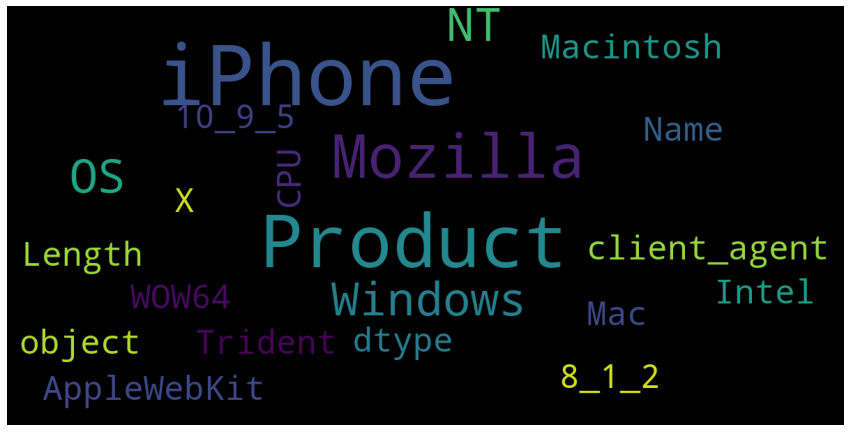

In [9]:
show_wordcloud(dataset['client_agent'])

In [10]:
dataset.isnull().sum()

session_id                         0
session_number                     0
client_agent                     219
device_details                     0
date                               0
purchased                          0
added_in_cart                      0
checked_out                        0
time_spent                      2327
client_agent_length              219
client_agent_semicolon_count     219
client_agent_version_count       219
browser_version                  229
device                             0
browser                            0
hand_held                          0
desktop                            0
others                             0
overallScore                       0
month                              0
year                               0
week                               0
dayOfWeek                          0
day                                0
dailyTraffic                       0
dailyTrafficPerDevice              0
dailyTrafficPerbrowser             0
d

In [11]:
dataset["client_agent"] = dataset["client_agent"].fillna('n/a')
dataset["client_agent_length"] = dataset["client_agent_length"].fillna(0)
dataset["client_agent_semicolon_count"] = dataset["client_agent_semicolon_count"].fillna(0)
dataset["client_agent_version_count"] = dataset["client_agent_version_count"].fillna(0)
dataset["browser_version"] = dataset["browser_version"].fillna('n/a')

In [12]:
dataset.isnull().sum()

session_id                         0
session_number                     0
client_agent                       0
device_details                     0
date                               0
purchased                          0
added_in_cart                      0
checked_out                        0
time_spent                      2327
client_agent_length                0
client_agent_semicolon_count       0
client_agent_version_count         0
browser_version                    0
device                             0
browser                            0
hand_held                          0
desktop                            0
others                             0
overallScore                       0
month                              0
year                               0
week                               0
dayOfWeek                          0
day                                0
dailyTraffic                       0
dailyTrafficPerDevice              0
dailyTrafficPerbrowser             0
d

In [13]:
dataset

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,client_agent_length,...,overallScore,month,year,week,dayOfWeek,day,dailyTraffic,dailyTrafficPerDevice,dailyTrafficPerbrowser,device_num
3696,0000ccfee64caa1d4ac5e2c025183bd5,77,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-07,1,0,0,175.537,26.0,...,0.982007,10,2019,41,0,7,22,11,9,3
111,0001351371faa5a11668bd7e595d718b,33,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,Desktop - IE,2020-02-28,1,0,0,849.612,68.0,...,0.982007,2,2020,9,4,28,17,8,2,5
2777,00061e9b19af901ed6172af75447e0fe,220,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,Desktop - Chrome,2020-02-22,0,0,0,40.830,102.0,...,0.000000,2,2020,8,5,22,26,11,7,5
5933,0007570f57deb464f48e062d9751cb95,3344,Product/4.7.0 iPhone/8.1,iPhone - iOS,2019-12-26,0,1,0,NaN,24.0,...,1.000000,12,2019,52,3,26,29,22,14,3
5204,0007799644b7b1eec55a6390deda8065,143,Product/4.1.1 iPhone/7.1.2,iPhone - iOS,2019-08-11,0,0,0,1046.787,26.0,...,0.000000,8,2019,32,6,11,30,12,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,ffdb27513dc4b81f146371ec20aa8196,187,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,Desktop - Chrome,2020-01-16,0,0,0,83.061,119.0,...,0.000000,1,2020,3,3,16,19,10,4,5
6834,ffdc0c7c301ab9528d0efc5e2435d4de,627,Product/4.6.0 iPhone/8.1,iPhone - iOS,2019-11-26,0,0,0,NaN,24.0,...,0.000000,11,2019,48,1,26,42,21,14,3
4702,ffde54e480e73edafefb3eecd209e66a,3212,Mozilla/5.0 (iPhone; CPU iPhone OS 8_1_2 like ...,iPhone - Web,2019-12-24,0,0,0,22.077,109.0,...,0.000000,12,2019,52,1,24,42,22,11,3
7267,ffe0e1239bf610cd92b6769fd284bc8c,1485,Product/4.1.1 iPhone/7.0.2,iPhone - iOS,2019-09-04,0,0,0,NaN,26.0,...,0.000000,9,2019,36,2,4,32,21,10,3


In [14]:
dataset.corr().style.background_gradient(cmap ='coolwarm')

,session_number,purchased,added_in_cart,checked_out,time_spent,client_agent_length,client_agent_semicolon_count,client_agent_version_count,hand_held,desktop,others,overallScore,month,year,week,dayOfWeek,day,dailyTraffic,dailyTrafficPerDevice,dailyTrafficPerbrowser,device_num
session_number,1.000000,-0.219457,0.004128,-0.062982,0.078437,-0.165386,-0.064838,-0.223878,0.009673,0.001579,-0.024570,-0.145082,0.074655,0.010379,0.070730,0.006846,0.011354,0.233520,0.360082,0.281476,-0.261315
purchased,-0.219457,1.000000,0.044784,0.176573,0.200762,0.058624,0.008766,0.069010,0.009756,-0.013197,0.006470,0.655528,-0.052782,0.057537,-0.058860,-0.005721,-0.015375,-0.072491,-0.116730,-0.101803,0.272977
added_in_cart,0.004128,0.044784,1.000000,0.213134,0.209807,-0.022542,0.061586,-0.014826,-0.003176,0.006424,-0.006603,0.686999,-0.043921,0.050055,-0.041419,-0.036994,0.009440,-0.020105,-0.052343,-0.008336,0.122896
checked_out,-0.062982,0.176573,0.213134,1.000000,0.157765,0.039280,0.009152,0.030195,-0.000463,0.001043,-0.001188,0.607178,-0.009714,0.013095,-0.011682,0.002739,-0.003550,0.002734,-0.019611,-0.026521,0.108779
time_spent,0.078437,0.200762,0.209807,0.157765,1.000000,-0.025433,-0.032025,-0.002716,0.017945,-0.012565,-0.012850,0.295618,0.013367,-0.030843,0.008201,0.000285,-0.030206,0.070030,0.110008,0.075365,0.069221
client_agent_length,-0.165386,0.058624,-0.022542,0.039280,-0.025433,1.000000,0.487803,0.805970,0.016501,-0.014498,-0.005589,0.034955,0.021760,0.020808,0.022520,0.011551,-0.000117,-0.038244,-0.137149,-0.267861,0.488898
client_agent_semicolon_count,-0.064838,0.008766,0.061586,0.009152,-0.032025,0.487803,1.000000,0.240019,0.002116,0.000528,-0.005762,0.044157,-0.025034,0.014729,-0.021789,0.008510,0.032465,-0.065582,-0.167893,-0.214668,0.179135
client_agent_version_count,-0.223878,0.069010,-0.014826,0.030195,-0.002716,0.805970,0.240019,1.000000,0.001257,-0.003139,0.003875,0.041770,-0.012701,0.066701,-0.018576,-0.001999,-0.015227,-0.039320,-0.183889,-0.218464,0.440171
hand_held,0.009673,0.009756,-0.003176,-0.000463,0.017945,0.016501,0.002116,0.001257,1.000000,-0.892929,-0.308381,0.003460,0.000843,-0.007321,-0.000389,0.002573,0.006140,-0.019303,-0.005656,-0.006677,-0.002049
desktop,0.001579,-0.013197,0.006424,0.001043,-0.012565,-0.014498,0.000528,-0.003139,-0.892929,1.000000,-0.152893,-0.003286,-0.001369,0.007840,0.000826,-0.000835,0.003318,0.019249,0.014348,0.014723,0.007749


In [15]:
dataset=pd.get_dummies(dataset,columns=['device_num','browser_version'],drop_first=True)

In [16]:
fin_features = list(set(dataset.columns) - set(["session_id","client_agent","date","device","browser","device_details","time_spent","index"]))
fin_features

['browser_version_160382',
 'browser_version_160375',
 'browser_version_150287',
 'browser_version_3.1.0',
 'browser_version_4.5.1',
 'device_num_3',
 'browser_version_4.1.1',
 'dailyTrafficPerDevice',
 'browser_version_4.7.0',
 'hand_held',
 'overallScore',
 'client_agent_semicolon_count',
 'others',
 'browser_version_4.2.2',
 'browser_version_3.2.1',
 'browser_version_4.6.0',
 'browser_version_160355',
 'browser_version_160447',
 'browser_version_4.0.0',
 'browser_version_150264',
 'dailyTraffic',
 'browser_version_3.4.0',
 'browser_version_319',
 'browser_version_2.5.1',
 'browser_version_245',
 'browser_version_160346',
 'browser_version_150288',
 'dailyTrafficPerbrowser',
 'browser_version_214',
 'browser_version_160309',
 'browser_version_9.80',
 'browser_version_4.2.0',
 'browser_version_160314',
 'day',
 'browser_version_150297',
 'browser_version_160393',
 'browser_version_7.0',
 'browser_version_160333',
 'browser_version_160360',
 'browser_version_160318',
 'browser_version_

In [17]:
dftrain, dftest  = dataset[dataset["time_spent"].isnull()==False], dataset[dataset["time_spent"].isnull()==True]
dftest.reset_index(drop=True, inplace=True)
target = np.log1p(dftrain['time_spent'])

In [18]:
# TF-IDF
v_1 = TfidfVectorizer(ngram_range=(1,3),stop_words="english", analyzer='word')
typ_tr =v_1.fit_transform(dftrain['client_agent'])
typ_ts =v_1.transform(dftest['client_agent'])


v_1c = TfidfVectorizer(ngram_range=(2,6),stop_words="english", analyzer='char')
typ_trc =v_1c.fit_transform(dftrain['client_agent'])
typ_tsc =v_1c.transform(dftest['client_agent'])

In [19]:
final_features = sparse.hstack((dftrain[fin_features],typ_tr,typ_trc)).tocsr()
final_featurest = sparse.hstack((dftest[fin_features],typ_ts ,typ_tsc)).tocsr()

In [20]:
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(real, predicted):
    real=np.expm1(real)
    predicted=np.expm1(predicted)
    return np.sqrt(mean_squared_log_error(real,predicted))
    

def rmsle_lgb(labels, preds):
    return 'rmsle', rmsle(preds,labels), False

In [21]:
X_trn, X_val, y_trn, y_val = train_test_split(final_features, target, test_size=0.25, random_state=1996)
X_test = final_featurest

### LightGBM

In [22]:
def learning_rate_010_decay_power_0995(current_iter): 
    base_learning_rate = 0.0009
    lr = base_learning_rate * np.power(.995, current_iter) 
    return lr if lr > 1e-4 else 1e-4

In [23]:
X=final_features
y=target

y_pred_tot=[]
err=[]
feature_importance_df = pd.DataFrame()

#For Stacking
lgbm_train_res = pd.DataFrame()
lgbm_test_res = pd.DataFrame()

from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=4,shuffle=True,random_state=1996)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    depth=10
    m=LGBMRegressor(n_estimators=2000,n_jobs=-1,learning_rate=0.005,max_depth=depth,num_leaves=2**depth-1)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=200,eval_metric="rmse")
    preds=m.predict(X_test,num_iteration=m.best_iteration_)
    #print(f"RMSLE is:",rmsle_lgb(y_test, preds))
    print(f"RMSLE is: {np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds)))}")
    err.append(np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds))))
    p = m.predict(final_featurest)
    y_pred_tot.append(p)
    
    lgbm_train_res["iteration_"+str(i)] = m.predict(X)
    lgbm_test_res["iteration_"+str(i)] = m.predict(final_featurest)
    i=i+1
    

Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 1.69608	training's l2: 2.8767	valid_1's rmse: 1.7795	valid_1's l2: 3.1666
Early stopping, best iteration is:
[1]	training's rmse: 1.76266	training's l2: 3.10698	valid_1's rmse: 1.76982	valid_1's l2: 3.13227
RMSLE is: 1.769821056948787
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 1.67272	training's l2: 2.79798	valid_1's rmse: 1.7944	valid_1's l2: 3.21988
Early stopping, best iteration is:
[1]	training's rmse: 1.76054	training's l2: 3.09949	valid_1's rmse: 1.77607	valid_1's l2: 3.15443
RMSLE is: 1.7760714363671377
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 1.69732	training's l2: 2.8809	valid_1's rmse: 1.79345	valid_1's l2: 3.21645
Early stopping, best iteration is:
[1]	training's rmse: 1.75733	training's l2: 3.08821	valid_1's rmse: 1.78601	valid_1's l2: 3.18982
RMSLE is: 1.786006242418537
Training until validation scores do

In [24]:
np.mean(err)

1.765108824391914

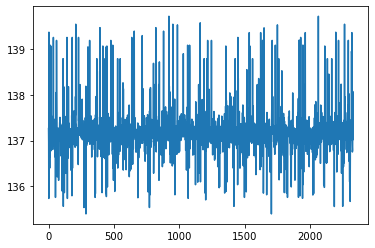

In [25]:
submission_lgbm = pd.DataFrame()
submission_lgbm["time_spent"] = np.expm1(np.mean(y_pred_tot,0))
submission_lgbm["time_spent"].plot()

### CatBoost

In [26]:
X=final_features
y=target

errmain=[]
y_pred_main=[]

#For Stacking
cb_train_res = pd.DataFrame()
cb_test_res = pd.DataFrame()

i=0
from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=4,shuffle=True,random_state=1996)
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    depth = 5
    rf=CatBoostRegressor(n_estimators=2000,eval_metric='RMSE',learning_rate=0.005,max_depth=depth)
    rf.fit(X_train,y_train,eval_set=[(X_test, y_test.values)],
           verbose=200,
           early_stopping_rounds=50
          )
    pr=rf.predict(X_test)
    print("errmain: ",np.sqrt(mean_squared_log_error(np.expm1(y_test.values),np.expm1(pr))))
    
    errmain.append(np.sqrt(mean_squared_log_error(np.expm1(y_test.values),np.expm1(pr))))
    pp = rf.predict(final_featurest)
    print(pp.shape)
    y_pred_main.append(pp)
    
    cb_train_res["iteration_"+str(i)] = rf.predict(X)
    cb_test_res["iteration_"+str(i)] = rf.predict(final_featurest)
    i=i+1

0:	learn: 1.7631558	test: 1.7698049	best: 1.7698049 (0)	total: 276ms	remaining: 9m 11s
200:	learn: 1.7575615	test: 1.7692693	best: 1.7692538 (198)	total: 39.1s	remaining: 5m 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.769253751
bestIteration = 198

Shrink model to first 199 iterations.
errmain:  1.7692537592176556
(2327,)
0:	learn: 1.7610659	test: 1.7760262	best: 1.7760262 (0)	total: 263ms	remaining: 8m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.7760262
bestIteration = 0

Shrink model to first 1 iterations.
errmain:  1.776026209182221
(2327,)
0:	learn: 1.7577884	test: 1.7860400	best: 1.7860400 (0)	total: 221ms	remaining: 7m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.785929168
bestIteration = 39

Shrink model to first 40 iterations.
errmain:  1.785929164754025
(2327,)
0:	learn: 1.7768434	test: 1.7285544	best: 1.7285544 (0)	total: 227ms	remaining: 7m 33s
Stopped by overfitting detector  (50 iterations w

In [27]:
np.mean(errmain)

1.7649408944478968

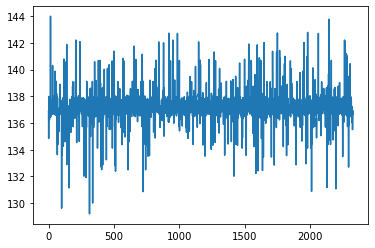

In [28]:
submission_cat = pd.DataFrame()
submission_cat["time_spent"] = np.expm1(np.mean(y_pred_main,0))
submission_cat["time_spent"].plot()

### XGBoost

In [29]:
y_pred_totxgb=[]
errx=[]
feature_importance_df = pd.DataFrame()

#For Stacking
xgb_train_res = pd.DataFrame()
xgb_test_res = pd.DataFrame()

from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=4,shuffle=True,random_state=1996)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    depth=5
    m=XGBRegressor(n_estimators=350,learning_rate=0.01,max_depth=depth,eval_metric ="rmse")
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=50,verbose=200)
    preds=m.predict(X_test)
    print(f"RMSLE is: {np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds)))}")
    errx.append(np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds))))
    #print(f"RMSLE is:",rmsle_lgb(y_test, preds))
    #errx.append(rmsle_lgb(y_test, preds))
    p = m.predict(final_featurest)
    y_pred_totxgb.append(p)
    
    xgb_train_res["iteration_"+str(i)] = m.predict(X)
    xgb_test_res["iteration_"+str(i)] = m.predict(final_featurest)
    i+=1

[1]	validation_0-rmse:4.69325	validation_1-rmse:4.66179
[2]	validation_0-rmse:4.65294	validation_1-rmse:4.62161
[3]	validation_0-rmse:4.61309	validation_1-rmse:4.58187
[4]	validation_0-rmse:4.57368	validation_1-rmse:4.54261
[5]	validation_0-rmse:4.53473	validation_1-rmse:4.50383
[6]	validation_0-rmse:4.49622	validation_1-rmse:4.46549
[7]	validation_0-rmse:4.45814	validation_1-rmse:4.42762
[8]	validation_0-rmse:4.42052	validation_1-rmse:4.39018
[9]	validation_0-rmse:4.38329	validation_1-rmse:4.35313
[10]	validation_0-rmse:4.34652	validation_1-rmse:4.31654
[11]	validation_0-rmse:4.31018	validation_1-rmse:4.28042
[12]	validation_0-rmse:4.27424	validation_1-rmse:4.24457
[13]	validation_0-rmse:4.23873	validation_1-rmse:4.20932
[14]	validation_0-rmse:4.20361	validation_1-rmse:4.17447
[15]	validation_0-rmse:4.16891	validation_1-rmse:4.14005
[16]	validation_0-rmse:4.13464	validation_1-rmse:4.10598
[17]	validation_0-rmse:4.10075	validation_1-rmse:4.07237
[18]	validation_0-rmse:4.06726	validatio

[145]	validation_0-rmse:2.00302	validation_1-rmse:2.03241
[146]	validation_0-rmse:1.99760	validation_1-rmse:2.02750
[147]	validation_0-rmse:1.99230	validation_1-rmse:2.02264
[148]	validation_0-rmse:1.98708	validation_1-rmse:2.01783
[149]	validation_0-rmse:1.98189	validation_1-rmse:2.01313
[150]	validation_0-rmse:1.97686	validation_1-rmse:2.00858
[151]	validation_0-rmse:1.97183	validation_1-rmse:2.00403
[152]	validation_0-rmse:1.96697	validation_1-rmse:1.99960
[153]	validation_0-rmse:1.96211	validation_1-rmse:1.99527
[154]	validation_0-rmse:1.95741	validation_1-rmse:1.99100
[155]	validation_0-rmse:1.95279	validation_1-rmse:1.98683
[156]	validation_0-rmse:1.94826	validation_1-rmse:1.98269
[157]	validation_0-rmse:1.94378	validation_1-rmse:1.97869
[158]	validation_0-rmse:1.93931	validation_1-rmse:1.97463
[159]	validation_0-rmse:1.93498	validation_1-rmse:1.97074
[160]	validation_0-rmse:1.93057	validation_1-rmse:1.96693
[161]	validation_0-rmse:1.92639	validation_1-rmse:1.96323
[162]	validati

[288]	validation_0-rmse:1.70835	validation_1-rmse:1.78892
[289]	validation_0-rmse:1.70784	validation_1-rmse:1.78865
[290]	validation_0-rmse:1.70725	validation_1-rmse:1.78837
[291]	validation_0-rmse:1.70680	validation_1-rmse:1.78814
[292]	validation_0-rmse:1.70633	validation_1-rmse:1.78783
[293]	validation_0-rmse:1.70579	validation_1-rmse:1.78762
[294]	validation_0-rmse:1.70528	validation_1-rmse:1.78730
[295]	validation_0-rmse:1.70483	validation_1-rmse:1.78708
[296]	validation_0-rmse:1.70426	validation_1-rmse:1.78693
[297]	validation_0-rmse:1.70381	validation_1-rmse:1.78672
[298]	validation_0-rmse:1.70322	validation_1-rmse:1.78645
[299]	validation_0-rmse:1.70284	validation_1-rmse:1.78628
[300]	validation_0-rmse:1.70241	validation_1-rmse:1.78609
[301]	validation_0-rmse:1.70199	validation_1-rmse:1.78588
[302]	validation_0-rmse:1.70147	validation_1-rmse:1.78566
[303]	validation_0-rmse:1.70107	validation_1-rmse:1.78549
[304]	validation_0-rmse:1.70070	validation_1-rmse:1.78526
[305]	validati

[82]	validation_0-rmse:2.58872	validation_1-rmse:2.64807
[83]	validation_0-rmse:2.57423	validation_1-rmse:2.63400
[84]	validation_0-rmse:2.56000	validation_1-rmse:2.62005
[85]	validation_0-rmse:2.54587	validation_1-rmse:2.60630
[86]	validation_0-rmse:2.53208	validation_1-rmse:2.59271
[87]	validation_0-rmse:2.51852	validation_1-rmse:2.57927
[88]	validation_0-rmse:2.50508	validation_1-rmse:2.56617
[89]	validation_0-rmse:2.49191	validation_1-rmse:2.55314
[90]	validation_0-rmse:2.47872	validation_1-rmse:2.54041
[91]	validation_0-rmse:2.46594	validation_1-rmse:2.52780
[92]	validation_0-rmse:2.45326	validation_1-rmse:2.51542
[93]	validation_0-rmse:2.44084	validation_1-rmse:2.50320
[94]	validation_0-rmse:2.42854	validation_1-rmse:2.49122
[95]	validation_0-rmse:2.41636	validation_1-rmse:2.47936
[96]	validation_0-rmse:2.40450	validation_1-rmse:2.46766
[97]	validation_0-rmse:2.39261	validation_1-rmse:2.45625
[98]	validation_0-rmse:2.38106	validation_1-rmse:2.44499
[99]	validation_0-rmse:2.36963	

[225]	validation_0-rmse:1.76035	validation_1-rmse:1.85647
[226]	validation_0-rmse:1.75895	validation_1-rmse:1.85533
[227]	validation_0-rmse:1.75747	validation_1-rmse:1.85427
[228]	validation_0-rmse:1.75622	validation_1-rmse:1.85316
[229]	validation_0-rmse:1.75494	validation_1-rmse:1.85204
[230]	validation_0-rmse:1.75362	validation_1-rmse:1.85098
[231]	validation_0-rmse:1.75241	validation_1-rmse:1.84991
[232]	validation_0-rmse:1.75113	validation_1-rmse:1.84889
[233]	validation_0-rmse:1.74975	validation_1-rmse:1.84787
[234]	validation_0-rmse:1.74862	validation_1-rmse:1.84689
[235]	validation_0-rmse:1.74736	validation_1-rmse:1.84594
[236]	validation_0-rmse:1.74608	validation_1-rmse:1.84509
[237]	validation_0-rmse:1.74495	validation_1-rmse:1.84415
[238]	validation_0-rmse:1.74380	validation_1-rmse:1.84331
[239]	validation_0-rmse:1.74271	validation_1-rmse:1.84241
[240]	validation_0-rmse:1.74164	validation_1-rmse:1.84151
[241]	validation_0-rmse:1.74063	validation_1-rmse:1.84058
[242]	validati

[18]	validation_0-rmse:4.04385	validation_1-rmse:4.12731
[19]	validation_0-rmse:4.01098	validation_1-rmse:4.09455
[20]	validation_0-rmse:3.97849	validation_1-rmse:4.06216
[21]	validation_0-rmse:3.94638	validation_1-rmse:4.03022
[22]	validation_0-rmse:3.91465	validation_1-rmse:3.99865
[23]	validation_0-rmse:3.88332	validation_1-rmse:3.96742
[24]	validation_0-rmse:3.85236	validation_1-rmse:3.93670
[25]	validation_0-rmse:3.82177	validation_1-rmse:3.90631
[26]	validation_0-rmse:3.79155	validation_1-rmse:3.87633
[27]	validation_0-rmse:3.76165	validation_1-rmse:3.84671
[28]	validation_0-rmse:3.73215	validation_1-rmse:3.81744
[29]	validation_0-rmse:3.70299	validation_1-rmse:3.78840
[30]	validation_0-rmse:3.67415	validation_1-rmse:3.75985
[31]	validation_0-rmse:3.64569	validation_1-rmse:3.73164
[32]	validation_0-rmse:3.61760	validation_1-rmse:3.70373
[33]	validation_0-rmse:3.58982	validation_1-rmse:3.67624
[34]	validation_0-rmse:3.56232	validation_1-rmse:3.64902
[35]	validation_0-rmse:3.53521	

[161]	validation_0-rmse:1.92174	validation_1-rmse:2.02802
[162]	validation_0-rmse:1.91760	validation_1-rmse:2.02401
[163]	validation_0-rmse:1.91365	validation_1-rmse:2.02011
[164]	validation_0-rmse:1.90969	validation_1-rmse:2.01625
[165]	validation_0-rmse:1.90561	validation_1-rmse:2.01243
[166]	validation_0-rmse:1.90168	validation_1-rmse:2.00865
[167]	validation_0-rmse:1.89799	validation_1-rmse:2.00498
[168]	validation_0-rmse:1.89426	validation_1-rmse:2.00141
[169]	validation_0-rmse:1.89070	validation_1-rmse:1.99789
[170]	validation_0-rmse:1.88708	validation_1-rmse:1.99438
[171]	validation_0-rmse:1.88360	validation_1-rmse:1.99097
[172]	validation_0-rmse:1.88014	validation_1-rmse:1.98764
[173]	validation_0-rmse:1.87682	validation_1-rmse:1.98428
[174]	validation_0-rmse:1.87343	validation_1-rmse:1.98100
[175]	validation_0-rmse:1.87011	validation_1-rmse:1.97775
[176]	validation_0-rmse:1.86696	validation_1-rmse:1.97464
[177]	validation_0-rmse:1.86385	validation_1-rmse:1.97155
[178]	validati

[304]	validation_0-rmse:1.69990	validation_1-rmse:1.82001
[305]	validation_0-rmse:1.69955	validation_1-rmse:1.81973
[306]	validation_0-rmse:1.69912	validation_1-rmse:1.81942
[307]	validation_0-rmse:1.69870	validation_1-rmse:1.81907
[308]	validation_0-rmse:1.69819	validation_1-rmse:1.81884
[309]	validation_0-rmse:1.69772	validation_1-rmse:1.81861
[310]	validation_0-rmse:1.69739	validation_1-rmse:1.81835
[311]	validation_0-rmse:1.69701	validation_1-rmse:1.81819
[312]	validation_0-rmse:1.69658	validation_1-rmse:1.81798
[313]	validation_0-rmse:1.69625	validation_1-rmse:1.81779
[314]	validation_0-rmse:1.69594	validation_1-rmse:1.81754
[315]	validation_0-rmse:1.69556	validation_1-rmse:1.81722
[316]	validation_0-rmse:1.69523	validation_1-rmse:1.81696
[317]	validation_0-rmse:1.69494	validation_1-rmse:1.81672
[318]	validation_0-rmse:1.69466	validation_1-rmse:1.81650
[319]	validation_0-rmse:1.69435	validation_1-rmse:1.81632
[320]	validation_0-rmse:1.69399	validation_1-rmse:1.81604
[321]	validati

[98]	validation_0-rmse:2.40275	validation_1-rmse:2.34274
[99]	validation_0-rmse:2.39134	validation_1-rmse:2.33179
[100]	validation_0-rmse:2.38015	validation_1-rmse:2.32105
[101]	validation_0-rmse:2.36911	validation_1-rmse:2.31042
[102]	validation_0-rmse:2.35817	validation_1-rmse:2.29981
[103]	validation_0-rmse:2.34745	validation_1-rmse:2.28950
[104]	validation_0-rmse:2.33683	validation_1-rmse:2.27943
[105]	validation_0-rmse:2.32637	validation_1-rmse:2.26938
[106]	validation_0-rmse:2.31612	validation_1-rmse:2.25961
[107]	validation_0-rmse:2.30604	validation_1-rmse:2.24993
[108]	validation_0-rmse:2.29605	validation_1-rmse:2.24047
[109]	validation_0-rmse:2.28613	validation_1-rmse:2.23102
[110]	validation_0-rmse:2.27643	validation_1-rmse:2.22183
[111]	validation_0-rmse:2.26694	validation_1-rmse:2.21283
[112]	validation_0-rmse:2.25752	validation_1-rmse:2.20388
[113]	validation_0-rmse:2.24834	validation_1-rmse:2.19520
[114]	validation_0-rmse:2.23930	validation_1-rmse:2.18659
[115]	validation

[241]	validation_0-rmse:1.76343	validation_1-rmse:1.76528
[242]	validation_0-rmse:1.76222	validation_1-rmse:1.76458
[243]	validation_0-rmse:1.76114	validation_1-rmse:1.76395
[244]	validation_0-rmse:1.76016	validation_1-rmse:1.76336
[245]	validation_0-rmse:1.75917	validation_1-rmse:1.76277
[246]	validation_0-rmse:1.75827	validation_1-rmse:1.76219
[247]	validation_0-rmse:1.75734	validation_1-rmse:1.76161
[248]	validation_0-rmse:1.75638	validation_1-rmse:1.76103
[249]	validation_0-rmse:1.75542	validation_1-rmse:1.76040
[250]	validation_0-rmse:1.75432	validation_1-rmse:1.75980
[251]	validation_0-rmse:1.75330	validation_1-rmse:1.75926
[252]	validation_0-rmse:1.75238	validation_1-rmse:1.75860
[253]	validation_0-rmse:1.75158	validation_1-rmse:1.75806
[254]	validation_0-rmse:1.75063	validation_1-rmse:1.75743
[255]	validation_0-rmse:1.74968	validation_1-rmse:1.75687
[256]	validation_0-rmse:1.74876	validation_1-rmse:1.75640
[257]	validation_0-rmse:1.74798	validation_1-rmse:1.75586
[258]	validati

In [30]:
np.mean(errx)

1.783712692982036

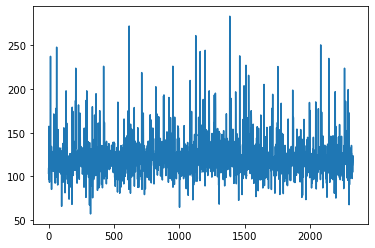

In [31]:
submission_xgb = pd.DataFrame()
submission_xgb["time_spent"] = np.expm1(np.mean(y_pred_totxgb,0))
submission_xgb["time_spent"].plot()

In [32]:
submission = pd.DataFrame()
submission["time_spent"] = submission_cat["time_spent"]*0.5 + submission_lgbm["time_spent"]*0.45 + submission_xgb["time_spent"]*0.05

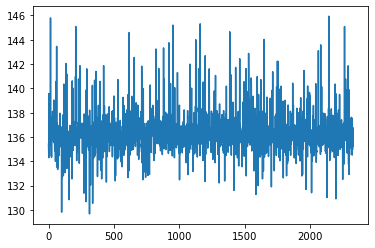

In [33]:
submission["time_spent"].plot()

In [34]:
submission.to_csv("dec_25_v13_lgbm_50+cb_45+xgb_5.csv",index=False)